Sistema de inferencia difusa de Mamdani
===

* 30 min | Última modificación: Junio 1, 2021 | [YouTube]

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Función de pertenencia y conjuntos difusos

* **Noción de dicotomia**. El conjunto $A$ definido sobre un universo de discurso $X$ tiene una función característica o de pertenencia definida como:

$$
\mu_A(x) = 
\begin{cases}
1, & \text{if } x \in A \\
0, & \text{if } x \notin A \\
\end{cases}
$$

* **Función de pertenencia**: $\mu_A(x) \to \{0,1\}$ indica si el elemento $x$ pertenece al conjunto $A$; es la modelación numérica del concepto.

* **Conjunto difuso**: Se obtiene al relajar la condición anterior, tal que $\mu_A(x) \to [0, 1]$, indicando condición parcial de pertenencia. El $0$ indica absoluta certeza de que no pertenece, y el $1$ absoluta certeza de que si pertenece.

## Variable difusa

Es una variable que esta definida sobre un universo $X$ y tiene varios conjuntos borrosos que representan los conceptos asociados

In [2]:
import matplotlib.pyplot as plt
import numpy as np


class FuzzyVariable:
    def __init__(self, name, universe, sets):
        #
        # Una variable difusa tiene definidos un nombre y 
        # un universo X. Y varios conjuntos difusos que 
        # son caracterizados por sus funciones de pertenencia
        #
        self.name = name
        self.universe = universe
        self.sets = sets

    def plot(self, figsize=(10, 3)):
        #
        # Grafíca la función de pertenencia de cada conjunto 
        # difuso definido para la variable
        #
        plt.figure(figsize=figsize)
        for k in self.sets.keys():
            plt.plot(self.universe, self.sets[k], "o-", label=k)
        plt.legend()
        plt.title(self.name)
        plt.ylim(-0.05, 1.05)

    def membership(self, value, fuzzyset):
        #
        # Computa el valor de la función de pertenencia
        # para x=value y el correspondiente conjunto difuso
        #
        return np.interp(
            x=value,
            xp=self.universe,
            fp=self.sets[fuzzyset],
        )
    
    def aggregate(self, operator="max"):
        #
        # Reduce los conjuntos que tiene definida la 
        # variable a un solo conjunto borroso usando el
        # operador indicado
        #
        
        aggregation = None
        
        for i_fuzzyset, fuzzyset in enumerate(self.sets.keys()):
            
            if i_fuzzyset == 0:
                aggregation = self.sets[fuzzyset]
            else:
                aggregation = np.maximum(aggregation, self.sets[fuzzyset])
                
        self.sets = {'aggregation': aggregation}
                
    def defuzzification(self, fuzzyset="aggregation", method='cog'):
        
        if method == 'cog':
            #
            # cog: center of gravity
            #
            num = sum([u * v  for u, v in zip(self.universe, self.sets[fuzzyset])])
            den = sum([u for u in self.sets[fuzzyset]])
            return num / den
                
                

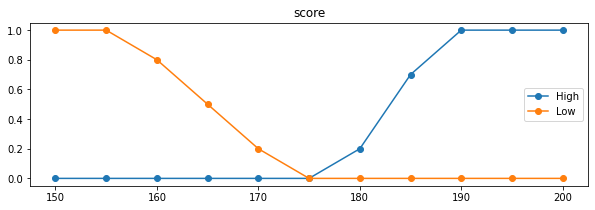

In [3]:
#
# En el siguiente código se define la variable difusa score
# la cual tiene asociadas las etiquetas linguisticas High y
# Low
#
score = FuzzyVariable(
    #
    # Nombre de la variable
    #
    name="score",
    
    #
    # Universo de valores sobre los que estan definidos los
    # conjuntos borrosos
    #
    universe=np.arange(start=150, stop=201, step=5),
    
    #
    # Se define cada conjunto borroso y los correspondientes
    # valores de la función de pertenencia para cada punto
    # del universo en que esta definida la variable
    #
    sets={
        "High": [0., 0., 0., 0., 0., 0., 0.2, 0.7, 1., 1., 1.],
        "Low": [1., 1., 0.8, 0.5, 0.2, 0., 0., 0., 0., 0., 0.],
    },
)

#
# Gráfica de la variable.
#
score.plot()

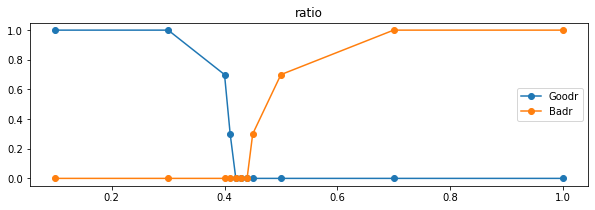

In [4]:
#
# Variable ratio
#
ratio = FuzzyVariable(
    name="ratio",
    universe=[0.1, 0.3, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.5, 0.7, 1.0],
    sets={
        "Goodr": [1, 1, 0.7, 0.3, 0, 0, 0, 0, 0, 0, 0],
        "Badr": [0, 0, 0, 0, 0, 0, 0, 0.3, 0.7, 1.0, 1.0],
    },
)

ratio.plot()

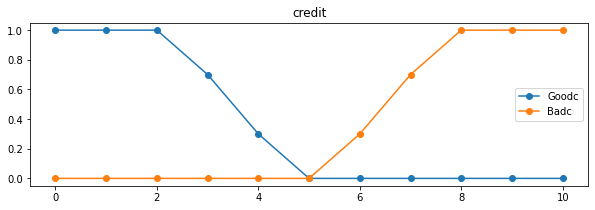

In [5]:
#
# Variable credit
#
credit = FuzzyVariable(
    name="credit",
    universe=list(range(11)),
    sets={
        "Goodc": [1, 1, 1, 0.7, 0.3, 0, 0, 0, 0, 0, 0],
        "Badc": [0, 0, 0, 0, 0, 0, 0.3, 0.7, 1, 1, 1],
    },
)

credit.plot()

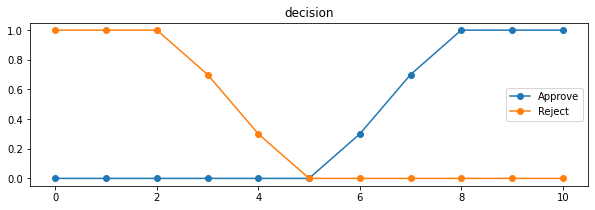

In [6]:
#
# Variable decision
#
decision = FuzzyVariable(
    name="decision",
    universe=list(range(11)),
    sets={
        "Approve": [0, 0, 0, 0, 0, 0, 0.3, 0.7, 1, 1, 1],
        "Reject": [1, 1, 1, 0.7, 0.3, 0, 0, 0, 0, 0, 0],
    },
)

decision.plot()

## Cómputo del valor de pertenencia

Dado un valor $x \in X$ es posible calcular el valor de la función de pertenencia. Por ejemplo, para la variable score:

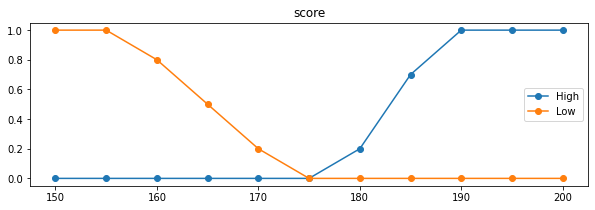

In [7]:
score.plot()

In [8]:
#
# Pertenencia de score=168 al conjunto Low
#
score.membership(168, "Low")

0.32

## Reglas difusas

Son reglas que usan variables difusas y conjuntos borrosos para expresar conceptos y reglas heurísticas. Por ejemplo:

*  **IF** score $\in$ "High" **AND** ratio $\in$ "Goodr" **AND** credit $\in$ "Goodc", **THEN** decision $\in$ Approve

*  **IF** score $\in$ "Low" **AND** ratio $\in$ "Badr" **AND** credit $\in$ "Badc", **THEN** decision $\in$ Reject



In [9]:
class Rule:
    def __init__(self, antecedents, consequent):
        #
        # La regla está representada por un grupo de
        # antecedente con el operador AND y un consecuente
        #
        self.antecedents = antecedents
        self.consequent = consequent

        #
        # Valores requeridos para computos internos
        #
        self.memberships = None
        self.output = None

    def consequent_universe(self):
        #
        # Esta función devuelve el universo de la
        # variable de salida
        #
        return self.consequent[0].universe

    def consequent_membership(self):
        #
        # Devuelve la función de pertenencia del conjunto
        # borroso de la variable de salida de la regla
        #
        return self.consequent[0].sets[self.consequent[1]]

    def consequent_name(self):
        #
        # Retorna el nombre de la variable de salida
        #
        return self.consequent[0].name

    def compute_memberships(self, **values):
        self.memberships = []
        for fuzzyvar, fuzzyset in self.antecedents:
            if fuzzyvar.name in values.keys():
                crisp_value = values[fuzzyvar.name]
                membership = fuzzyvar.membership(crisp_value, fuzzyset)
                self.memberships.append(membership)

    def compute_composition(self, composition, **values):
        self.compute_memberships(**values)
        if composition == "max-min":
            self.compute_compositon_maxmin()
        if composition == "max-product":
            self.compute_composition_maxproduct()

    def compute_compositon_maxmin(self):
        factor = np.min(self.memberships)
        membership = self.consequent_membership()
        self.output = FuzzyVariable(
            name=self.consequent_name(),
            universe=self.consequent_universe(),
            sets={
                "rule_output": np.where(
                    membership >= factor,
                    factor,
                    membership,
                )
            },
        )

    def compute_composition_maxproduct(self):
        factor = np.prod(self.memberships)
        membership = self.consequent_membership()
        self.output = FuzzyVariable(
            name=self.consequent_name(),
            universe=self.consequent_universe(),
            sets={"rule_output": np.array(membership) * factor},
        )

In [10]:
#
# IF score IS High
#    AND ratio IS Goodr
#    AND credit IS Goodc
# THEN
#    decision IS Approve
#
rule_1 = Rule(
    antecedents=[
        (score, "High"),
        (ratio, "Goodr"),
        (credit, "Goodc"),
    ],
    consequent=(decision, "Approve"),
)

In [11]:
#
# IF score IS Low
#    AND ratio IS Badr
#    AND credit IS Badc
# THEN
#    decision IS Reject
#
rule_2 = Rule(
    antecedents=[
        (score, "Low"),
        (ratio, "Badr"),
        (credit, "Badc"),
    ],
    consequent=(decision, "Reject"),
)

## Sistema de inferencia difusa

Es un sistema de reglas difusas que permite realizar inferencia y obtener resultados. Esta compuesto por los siguientes elementos:

* Entrada.

* Fuzzifier.

* Fuzzy knowledge base.

* Infernce engine.

* Defuzzifier. 

## Composición max-product

La composión es el proceso de obtener la salida del sistema de inferencia difusa para una entrada determinada. Esta compuesto por dos partes:

* El cálculo del consecuente de cada regla.

* La agregación de los consecuentes de las reglas.

In [12]:
#
# El primer paso consiste en el cómputo de las pertenencias
# para los datos de entrada. Por ejemplo, si
#
# * score = 185,
# * ratio = 0.22, y
# * credit = 2.5
#
# Las pertenencias para la primera regla son:
# 
rule_1.compute_memberships(score=185, ratio=0.22, credit=2.5,)
rule_1.memberships

[0.7, 1.0, 0.85]

In [13]:
#
# Mientras que para la segunda regla son:
#
rule_2.compute_memberships(score=185, ratio=0.22, credit=2.5,)
rule_2.memberships

[0.0, 0.0, 0.0]

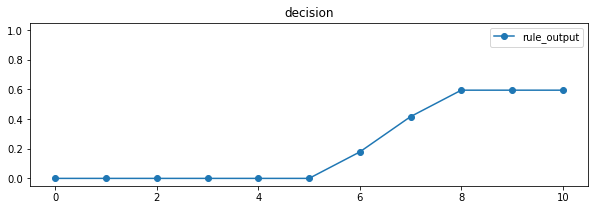

In [14]:
#
# El cálculo del consecuente se realiza como la
# multiplicación de las pertenencias por el valor de la
# función de pertenencia del consecuente.
#
# Para la primera regla es 0.7 x 1.0 x 0.85 x la función de
# pertenencia de decision IS Aprove
#
# 0.595 = 0.7 x 1.0 x 0.85
#
rule_1.compute_composition(
    composition="max-product",
    score=185,
    ratio=0.22,
    credit=2.5,
)
rule_1.output.plot()

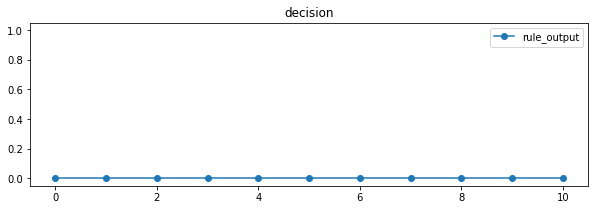

In [15]:
#
# Para la segunda regla es:
#
rule_2.compute_composition(
    composition="max-product",
    score=185,
    ratio=0.22,
    credit=2.5,
)
rule_2.output.plot()

La segunda parte de la composición consiste en agregar los dos conjutos de salida (uno por cada regla). Esto se hace mediante el operador max aplicado punto a punto sobre cada punto del universo de la variable. En este caso es igual a la salida de la primera regla.

## Composición max-min

In [16]:
#
# El primer paso consiste en el cómputo de las pertenencias
# para los datos de entrada. Por ejemplo, si
#
# * score = 185,
# * ratio = 0.22, y
# * credit = 2.5
#
# Las pertenencias para la primera regla son:
# 
rule_1.compute_memberships(score=185, ratio=0.22, credit=2.5,)
rule_1.memberships

[0.7, 1.0, 0.85]

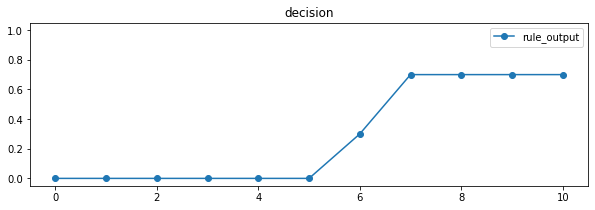

In [17]:
#
# El cálculo del consecuente se realiza asi:
# 
# * Se calcula el mínimo de las funciones de pertenencia u
#
# * El valor del consecuente es el máximo entre u y el 
#   valor de la función de pertenencia
#
rule_1.compute_composition(
    composition="max-min",
    score=185,
    ratio=0.22,
    credit=2.5,
)
rule_1.output.plot()

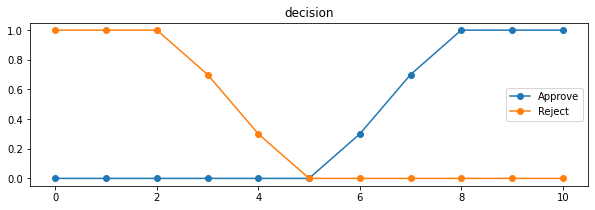

In [18]:
#
# La gráfica anterior es el minimo entre el valor de la 
# función de pertenencia para decision IS Approve y 0.595
decision.plot()

## Especificación de un modelo de Mamdani

In [19]:
class Mamdani:
    #
    # El modelo está conformado por:
    #
    # * El conjunto de reglas
    # * El operador de composición
    # * El operador de agregación de los consecuentes de
    #   las reglas
    # * El operador de defuzzification
    #
    def __init__(
        self,
        rules,
        composition="max-min",
        aggregation="max",
        defuzzification="cog",
    ):
        self.rules = rules
        self.composition = composition
        self.aggregation = aggregation
        self.defuzzification = defuzzification
        #
        self.output = None
        self.values = None

    def __call__(self, **values):
        #
        # El proceso de calculo contiene siguientes pasos
        #
        self.values = values
        self.compute_composition()
        self.compute_aggregation()
        return self.compute_defuzzification()

    def compute_composition(self):
        #
        # Calcula el consecuente de cada regla usando el
        # operador de composición especificado.
        #
        for rule in self.rules:
            rule.compute_composition(self.composition, **self.values)

    def compute_aggregation(self):

        #
        # Se geenera una variable difusa cuyos conjuntos
        # borrosos son los resultados de cada regla difusa
        #
        for i_rule, rule in enumerate(self.rules):
            if i_rule == 0:
                self.output = FuzzyVariable(
                    name="output",
                    universe=rule.output.universe,
                    sets={"rule_{}".format(i_rule): rule.output.sets["rule_output"]},
                )
            else:
                self.output.sets["rule_{}".format(i_rule)] = rule.output.sets[
                    "rule_output"
                ]

        #
        # Agrega los conjuntos borrosos para obtener uno
        # solo (el código aparece en la definición de la
        # clase)
        #
        self.output.aggregate()

    def compute_defuzzification(self):
        #
        # El conjunto borroso se convierte en un valor
        # crisp
        #
        return self.output.defuzzification()

8.425


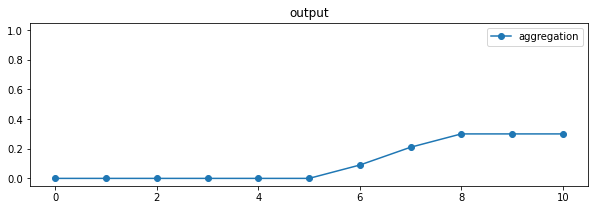

In [20]:
#
# Especificación del sistema
#
mamdani = Mamdani(
    rules=[
        rule_1,
        rule_2,
    ],
    composition="max-product",
)

#
# Valor computado para una entrada específica
#
print(
    mamdani(
        score=191,
        ratio=0.1,
        credit=4,
    )
)

#
# Conjuto borroso obtenido despues de agregar las salidas
# de las reglas borrosas
#
mamdani.output.plot()